# Grammar and Online Product Reviews

A list of 71,045 online reviews from 1,000 different products

---

## About This Data
[__download dataset__](https://www.kaggle.com/datasets/datafiniti/grammar-and-online-product-reviews)

This is a list of over 71,045 reviews from 1,000 different products provided by Datafiniti's Product Database. The dataset includes the text and title of the review, the name and manufacturer of the product, reviewer metadata, and more.

Note that this is a sample of a large dataset. The full dataset is available through Datafiniti.


## What You Can Do With This Data
You can use this data to assess how writing quality impacts positive and negative online product reviews. E.g.:

- Do reviewers use punctuation correctly?
- Does the number of spelling errors differ by rating?
- What is the distribution of star ratings across products?
- How does review length differ by rating?
- How long is the typical review?
- What is the frequency of words with spelling errors by rating?
- What is the number of reviews that don’t end sentences with punctuation?
- What is the proportion of reviews with spelling errors?

In [24]:
%matplotlib inline
import re
import string
from collections import Counter

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style("whitegrid")
matplotlib.rcParams['figure.figsize'] = (10, 6)

## Load Data:

In [2]:
data = pd.read_csv('../Data/GrammarandProductReviews.csv')
data.head(2)

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71044 entries, 0 to 71043
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    71044 non-null  object 
 1   brand                 71044 non-null  object 
 2   categories            71044 non-null  object 
 3   dateAdded             71044 non-null  object 
 4   dateUpdated           71044 non-null  object 
 5   ean                   39065 non-null  object 
 6   keys                  71044 non-null  object 
 7   manufacturer          70903 non-null  object 
 8   manufacturerNumber    70841 non-null  object 
 9   name                  71044 non-null  object 
 10  reviews.date          70977 non-null  object 
 11  reviews.dateAdded     71044 non-null  object 
 12  reviews.dateSeen      71044 non-null  object 
 13  reviews.didPurchase   32158 non-null  object 
 14  reviews.doRecommend   60429 non-null  object 
 15  reviews.id         

## Data Preprocessing:

- Select Important features for our task.
- Replace missing values.
- Rename columns for simplicity and readablity

In [4]:
# we can take few columns to our consideration as the part of feature engineering.
# since some columns are nearly empty holding null values.

df = data[['id', 'name', 'reviews.didPurchase', 'reviews.text', 'reviews.rating']]
df.rename(
    columns={
        'name': 'product_name',
        'reviews.didPurchase': 'purchased',
        'reviews.text': 'review_text', 
        'reviews.rating': 'ratings'
    }, inplace=True)

df.head()

,id,product_name,purchased,review_text,ratings
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),NaN,i love this album. it's very good. more to the...,5
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,True,Good flavor. This review was collected as part...,5
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,True,Good flavor.,5
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,False,I read through the reviews on here before look...,1
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,False,My husband bought this gel for us. The gel cau...,1


In [5]:
df.isna().sum()

id                  0
product_name        0
purchased       38886
review_text        36
ratings             0
dtype: int64

In [6]:
df.dropna(subset='review_text', inplace=True)
# will treat null values of purchased column bit later
df.isna().sum()

id                  0
product_name        0
purchased       38852
review_text         0
ratings             0
dtype: int64

# Visualizations 📊

--------

## User Ratings.

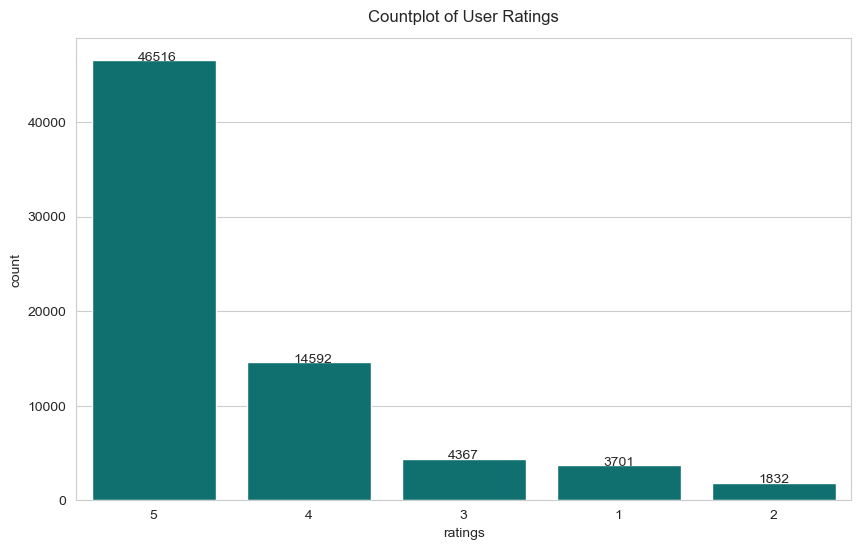

In [7]:
fig = sns.countplot(
    data=df, x=df['ratings'], order=df['ratings'].value_counts().index, color='teal')

for p, label in zip(fig.patches, df.ratings.value_counts()):
    fig.annotate(label, (p.get_x() + .30, p.get_height() + .5))

fig.set_title('Countplot of User Ratings', pad=12)
plt.show()

# Fake Reviews vs Genuine Reiviews 🎌
----
## Null Values:

- This __reviews.didPurchased__ (purchased) columm has over __38 thousand null values__.
- Replacing null values with 'No-review-given' or N/A can help __determine__ the __fake reviews__ posted by the people.
- Sometimes people can be lazy. They might not post a review even though the product is good.
- Null reviews are may be generated by bot / or may be spams to promot that product.. simply put - they are fake reviews otherwise there should be entry of the reivew in that respective column.

_this is my intuition, please go with yours or suggest some of your thought or correct me.. Would be great help_

In [8]:
df['purchased'] = df['purchased'].replace(np.NaN, 'N/A')

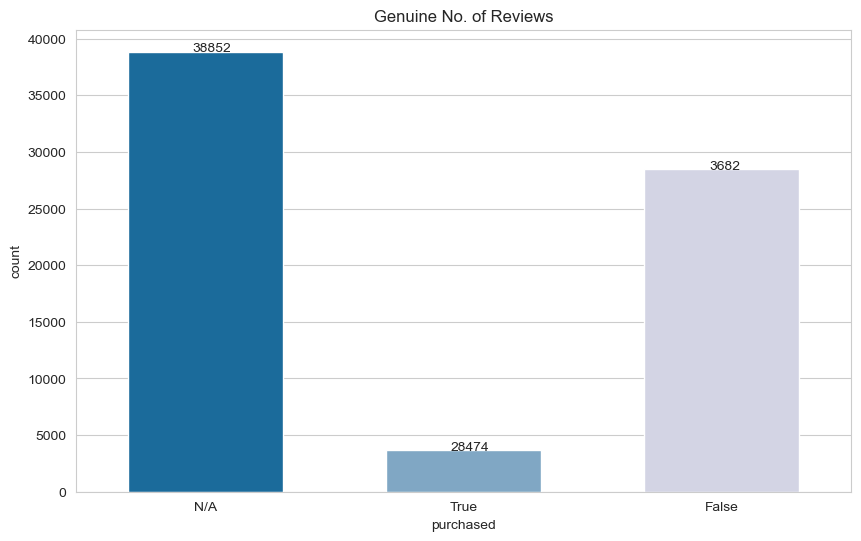

In [9]:
fig = sns.countplot(
    data=df, 
    x='purchased',  
    order=df['purchased'].value_counts().index, 
    width=.6, 
    palette='PuBu_r'
);
for p, label in zip(fig.patches, df.purchased.value_counts()):
    fig.annotate(label, (p.get_x() + .25, p.get_height() + .5))

fig.set_title('Genuine No. of Reviews')
plt.show()

## Groupby Products 📚

In [10]:
# df.groupby('product_name').count()
df_prods = df.groupby('id').filter(lambda x: len(x) >= 300)
df_product_groups = df.groupby('id')

len(df_product_groups)

598

- So there are total 598 unique products in this dataset.

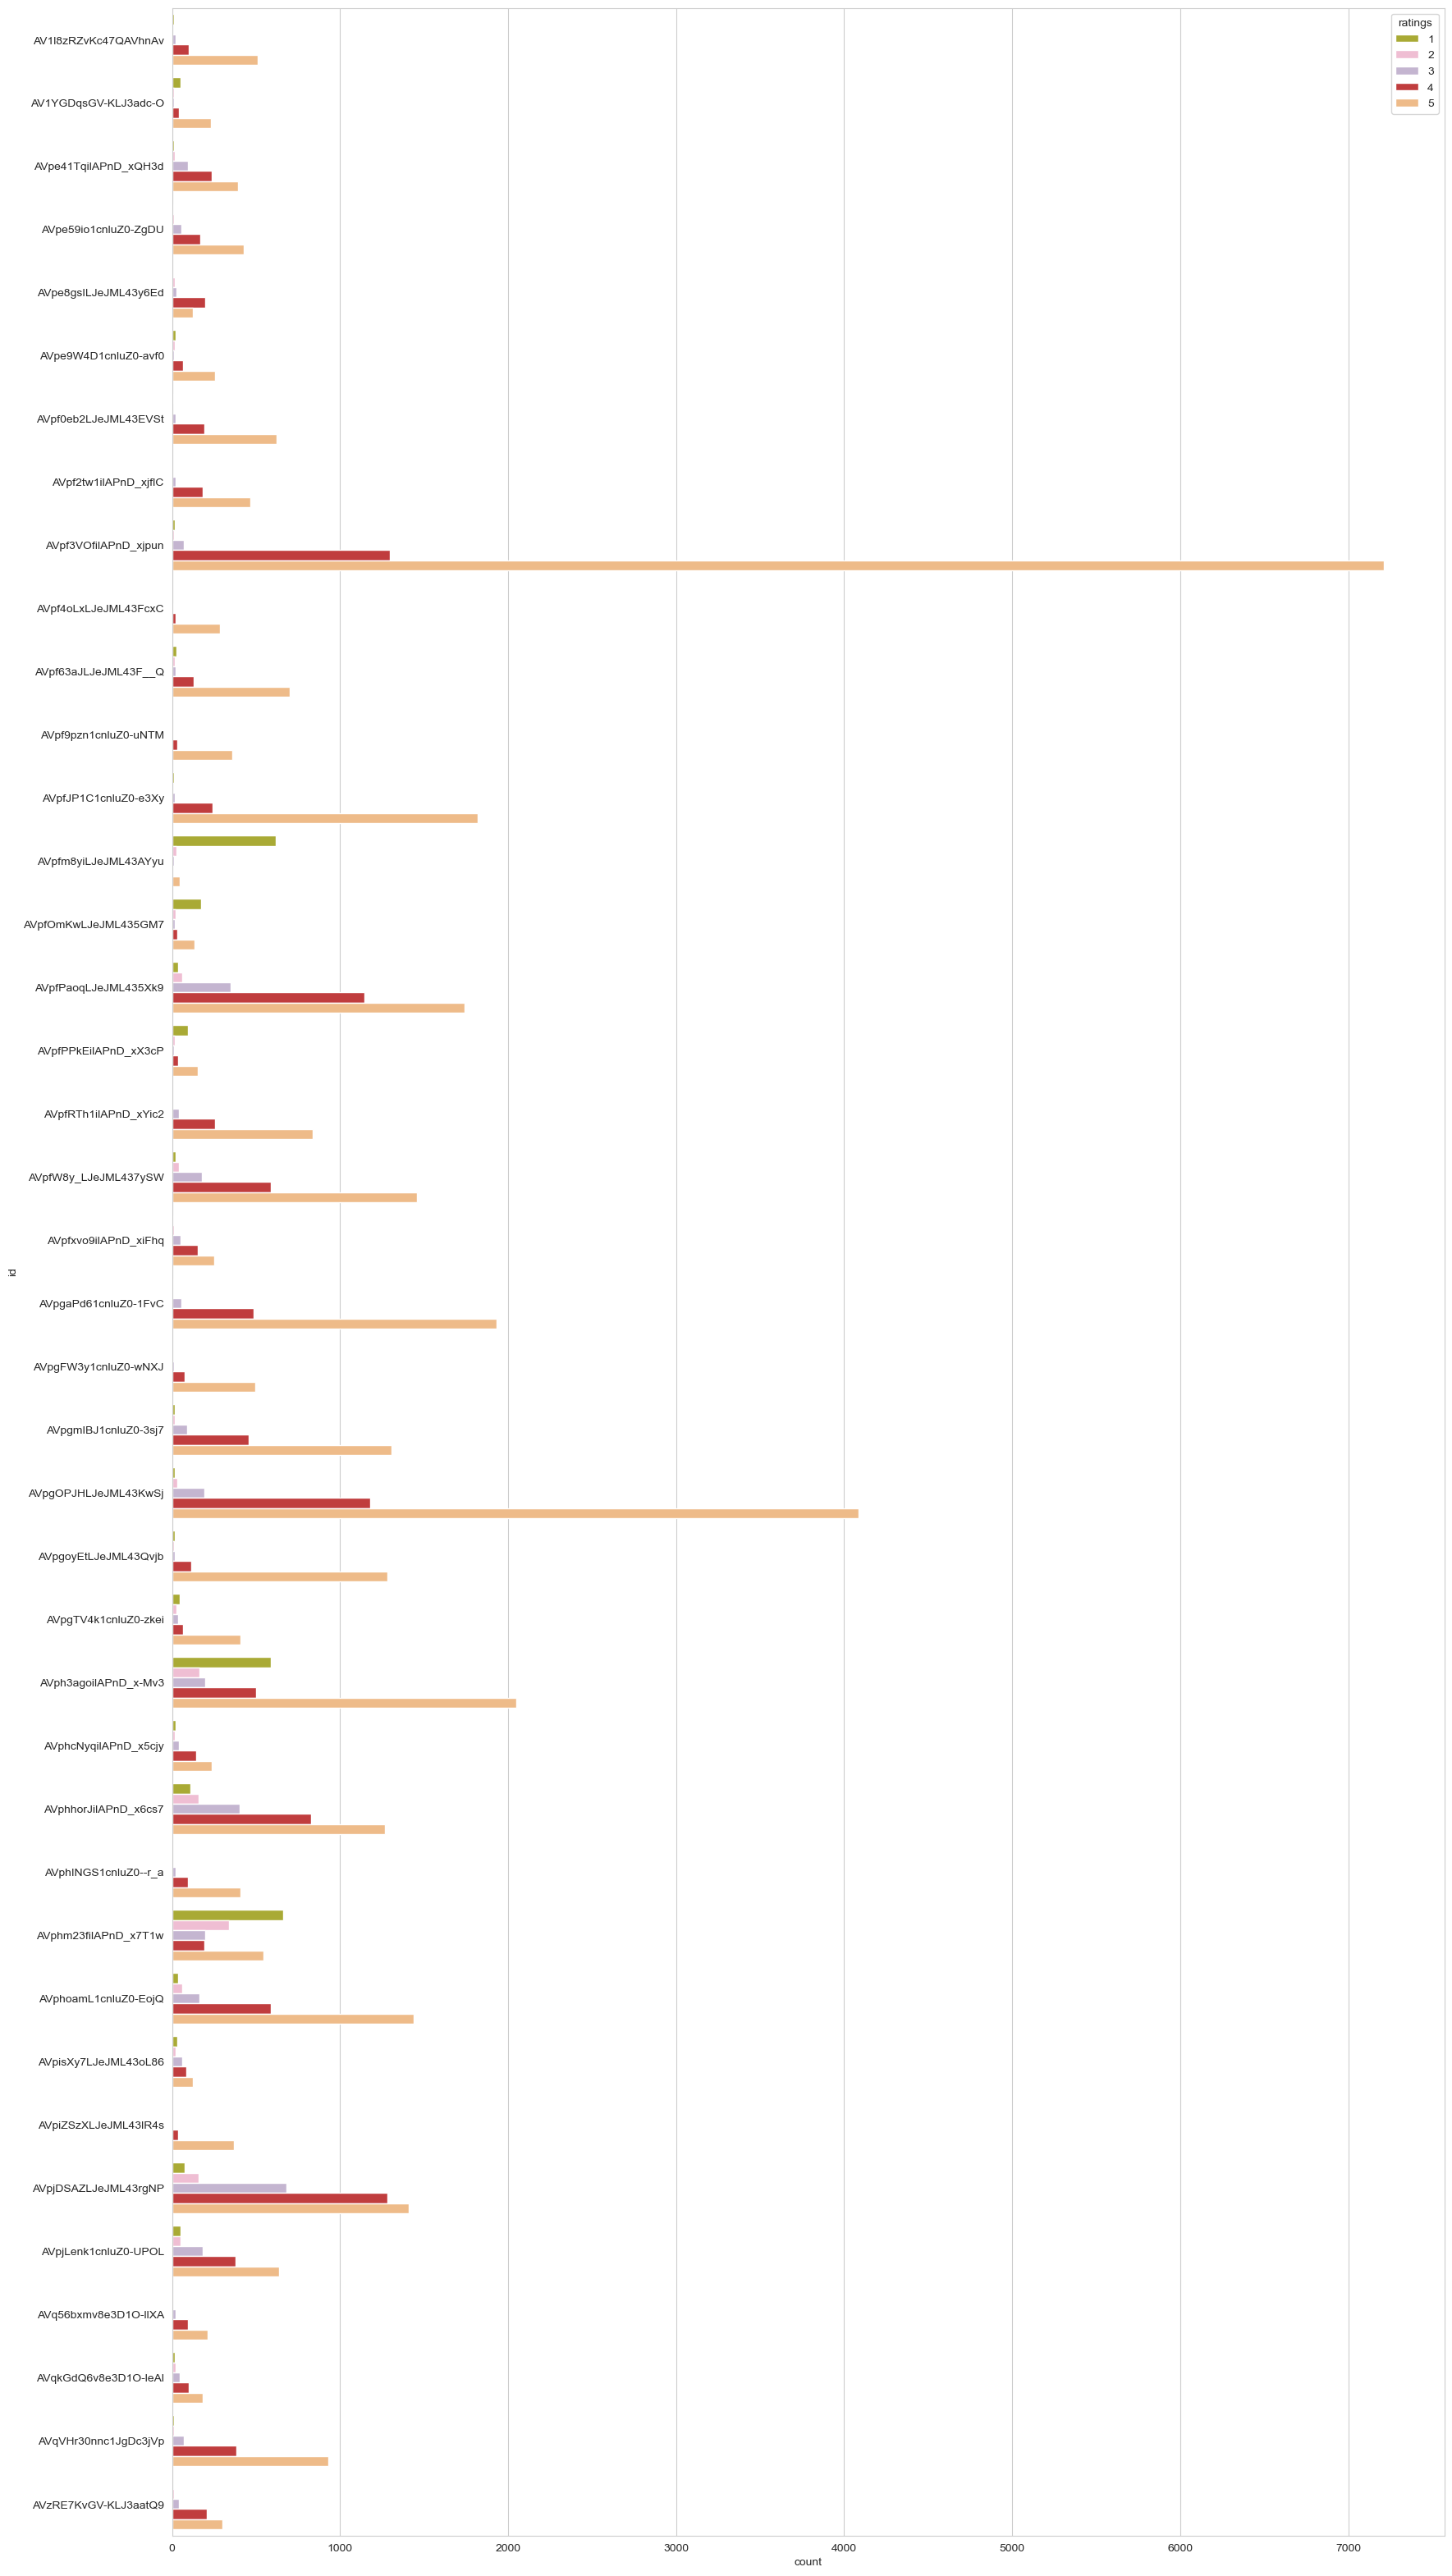

In [11]:
plt.figure(figsize=(20,40), dpi=100)
sns.countplot(y="id",  hue="ratings", data=df_prods, palette='tab20_r')
plt.savefig('../Data/groupby_products.png')
plt.show()

## Top 10 Sold/Selling products 🔋

- Rather than using product names to show top selling products use id of that product.

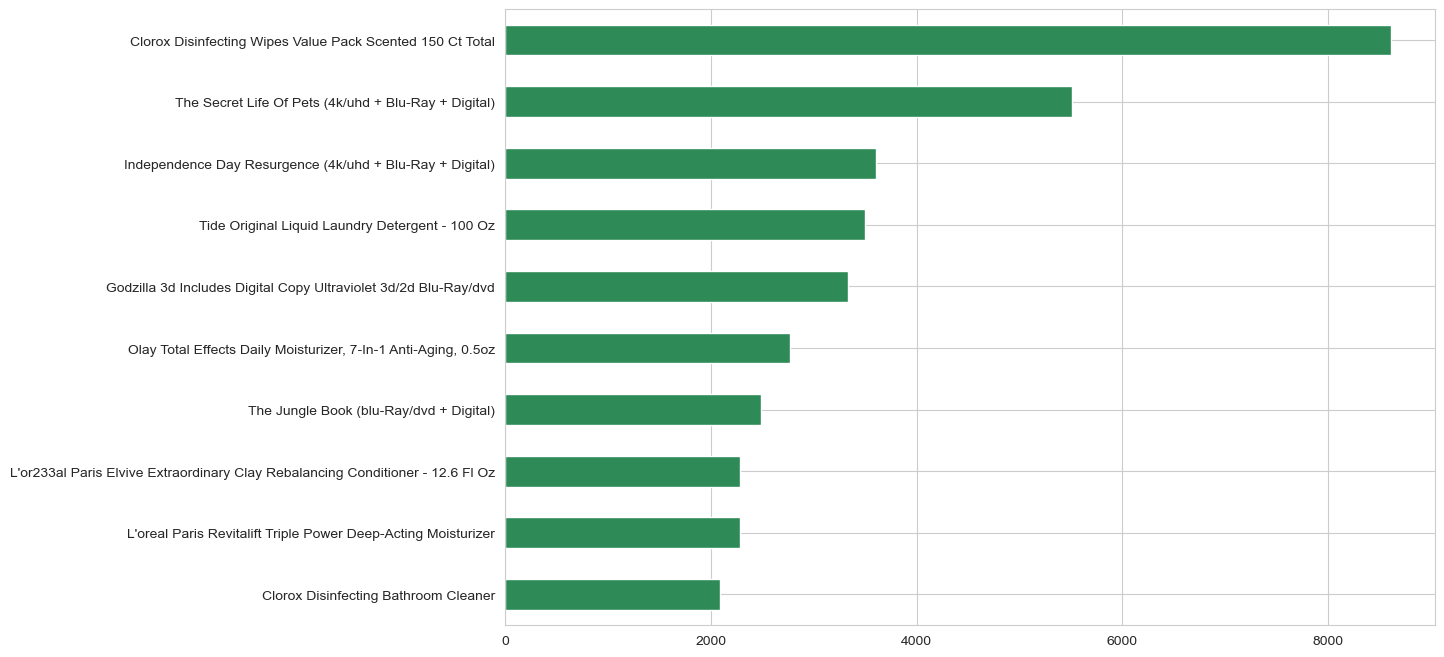

In [12]:
# - top 10 products: 
top_products = df.product_name.value_counts().nlargest(10).sort_values(ascending=True)

top_products.plot.barh(color='seagreen', figsize=(12, 8));

## Length of the Review 🧪

In [13]:
df['review_length'] = df['review_text'].apply(len)
df.head()

,id,product_name,purchased,review_text,ratings,review_length
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),N/A,i love this album. it's very good. more to the...,5,201
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,True,Good flavor. This review was collected as part...,5,62
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,True,Good flavor.,5,12
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,False,I read through the reviews on here before look...,1,696
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,False,My husband bought this gel for us. The gel cau...,1,132


<Figure size 1000x2800 with 0 Axes>

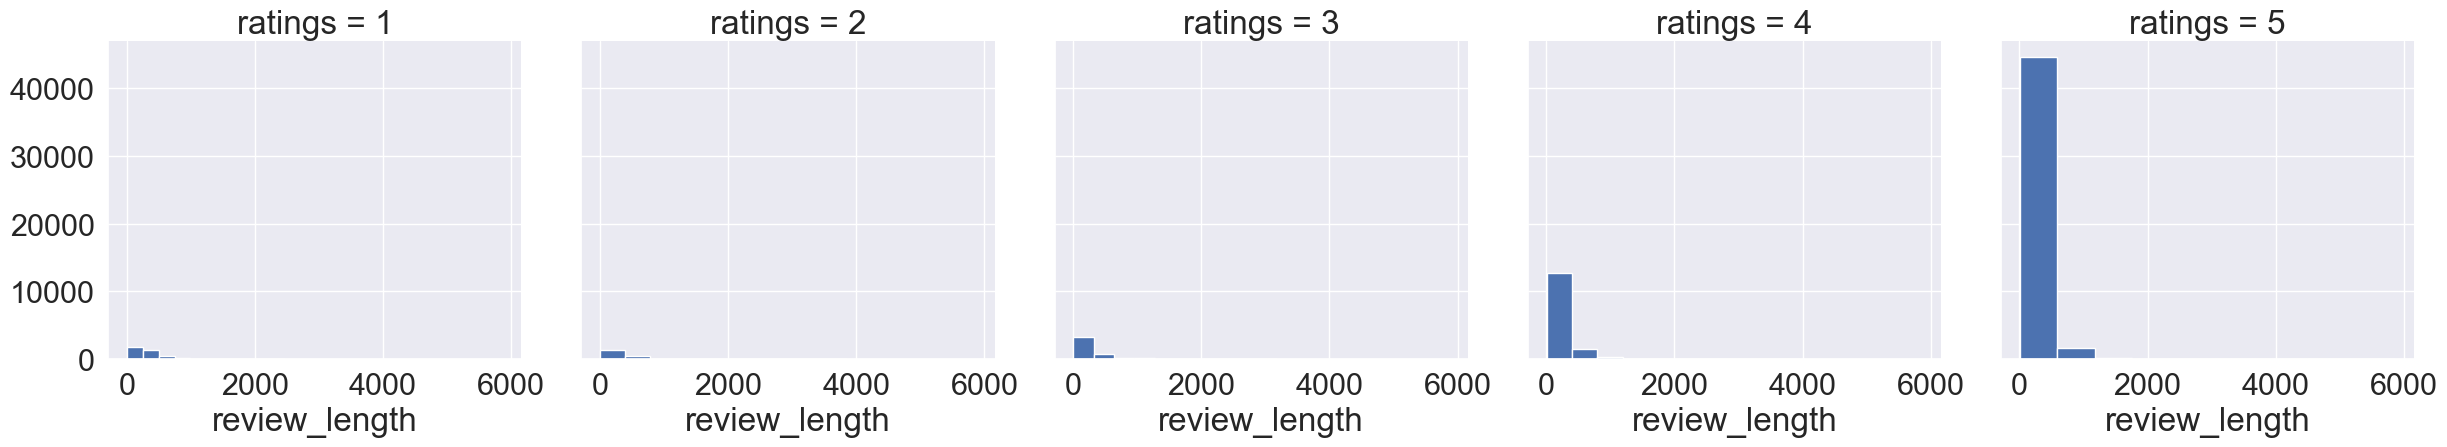

In [14]:
sns.set(font_scale=2.0)

plt.figure(figsize=(10, 28))
g = sns.FacetGrid(df,col='ratings', height=5)
g.map(plt.hist,'review_length',);

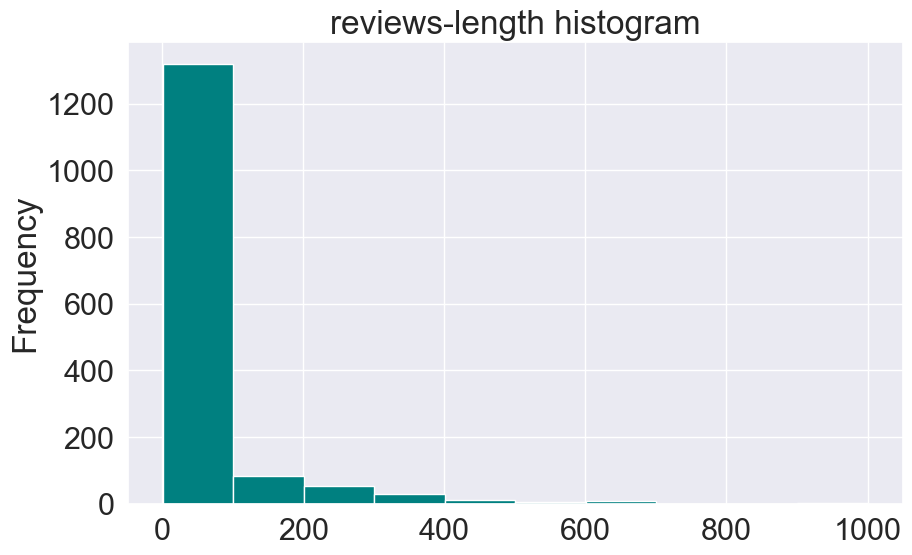

In [15]:
plt.title('reviews-length histogram')
df['review_length'].value_counts().plot(kind='hist', color='teal');

- __Explanation__:
- first tower. : There are more than 1200 reviews which are in length of 0-100(words) posted by users.

- 600: There is one review posted by a user which has the length of 600 words.

# Text Cleaning & Preprocessing:

In [16]:
reviews = df[['review_text', 'review_length', 'ratings']]
reviews.head()

,review_text,review_length,ratings
0,i love this album. it's very good. more to the...,201,5
1,Good flavor. This review was collected as part...,62,5
2,Good flavor.,12,5
3,I read through the reviews on here before look...,696,1
4,My husband bought this gel for us. The gel cau...,132,1


In [18]:
def clean_text(text):
    '''Make text lowercase, remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower() 
    text = re.sub('\[.*?\]', '', text) ## remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) ## remove links
    text = re.sub('<.*?>+', '', text) 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    text = re.sub('\n', '', text) ## remove newlines
    text = re.sub('\w*\d\w*', '', text) ## removes any alphanumeric sequence 
    text = re.sub(' +', ' ', text)
    return text


def remove_stopwords(text: str):
    stoppies = stopwords.words('english')
    more_stoppies = ['im', 'u', 'c', ]
    stoppies = stoppies + more_stoppies
    
    words = text.split(' ')
    words = [word for word in words if word not in stoppies]
    text = ' '.join(words)
    return text


def stem_text(text: str) -> str:
    stemmer = SnowballStemmer('english')
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [19]:
# - preprocess text
reviews['cleaned_reviews'] = reviews['review_text'].apply(clean_text)

# - remove stopwords
reviews['cleaned_reviews'] = reviews['cleaned_reviews'].apply(remove_stopwords)

# - stemming 
reviews['cleaned_reviews'] = reviews['cleaned_reviews'].apply(stem_text)

In [20]:
reviews['cleaned_reviews'].values[:2]

array(['love album good hip hop side current pop sound hype listen everyday gym give rating way metaphors crazy',
       'good flavor review collected part promotion', 'good flavor',
       'read reviews looking buying one couples lubricants ultimately disappointed didnt even live reviews read starters neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting disappointed paid much lube wont use could use normal personal lubricant less money less mess',
       'husband bought gel us gel caused irritation felt like burning skin wouldnt recommend gel',
       'boyfriend bought spice things bedroom highly disappointed product bought one absolutely love ky mine thought would similar affect absolutely nothing buy',
       'bought earlier today excited check based product description expecting something like regular ky fans expected left litt

# Check which words are appearing most in all reviews 📋

In [21]:
nested_text_list = reviews.cleaned_reviews.str.split()
flatlist = [element for inner_list in nested_text_list for element in inner_list]

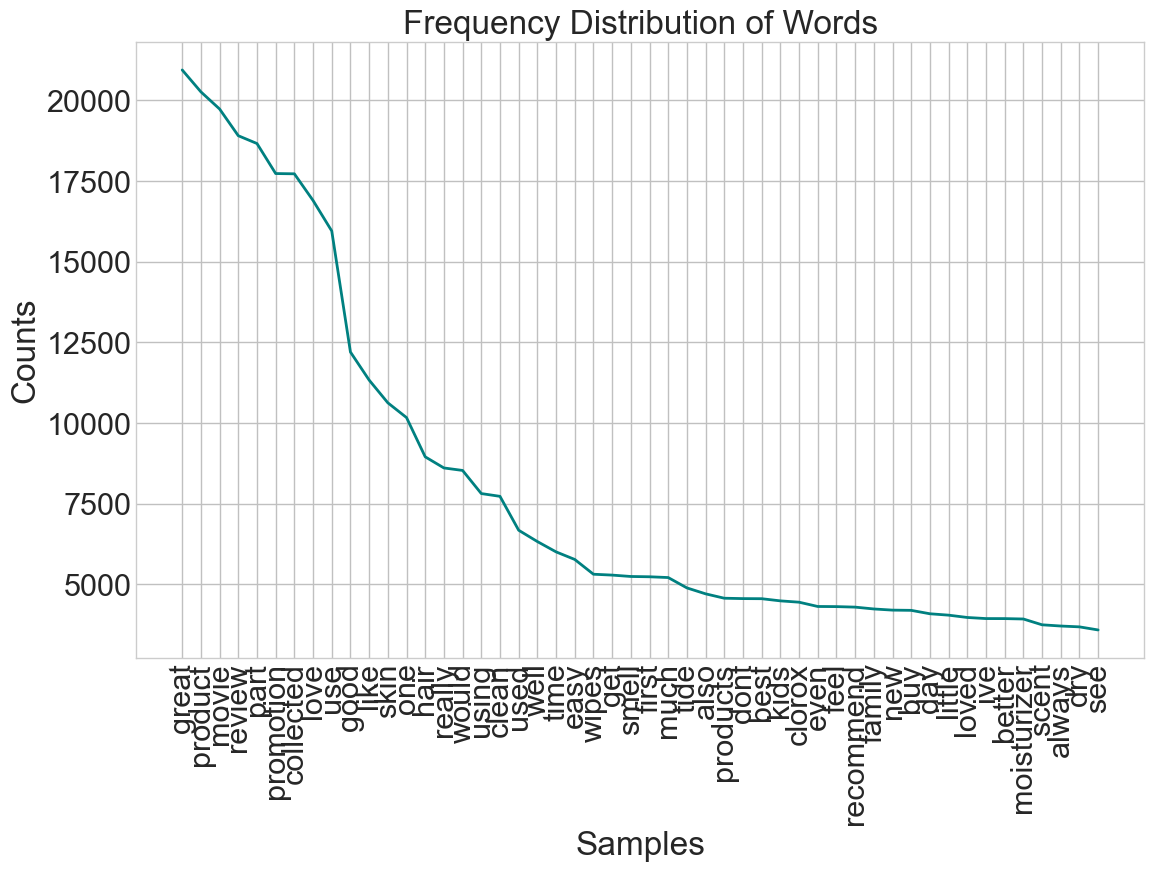

In [23]:
plt.figure(figsize=(13, 8))
plt.style.use('seaborn-whitegrid')
freq_dist = FreqDist(flatlist)
freq_dist.plot(50, cumulative=False, color='teal', title="Frequency Distribution of Words")
plt.show()

In [39]:
reviews.ratings.value_counts()

5    46516
4    14592
3     4367
1     3701
2     1832
Name: ratings, dtype: int64

In [41]:
positive_revs = reviews[reviews['ratings'] == 5]
negative_revs = reviews[reviews['ratings'] == 1]

neutral_fiter = (reviews['ratings'] == 2) | (reviews['ratings'] == 3)
neutral_reviews = reviews.loc[neutral_fiter]

## Frequency of words in positive reviews:

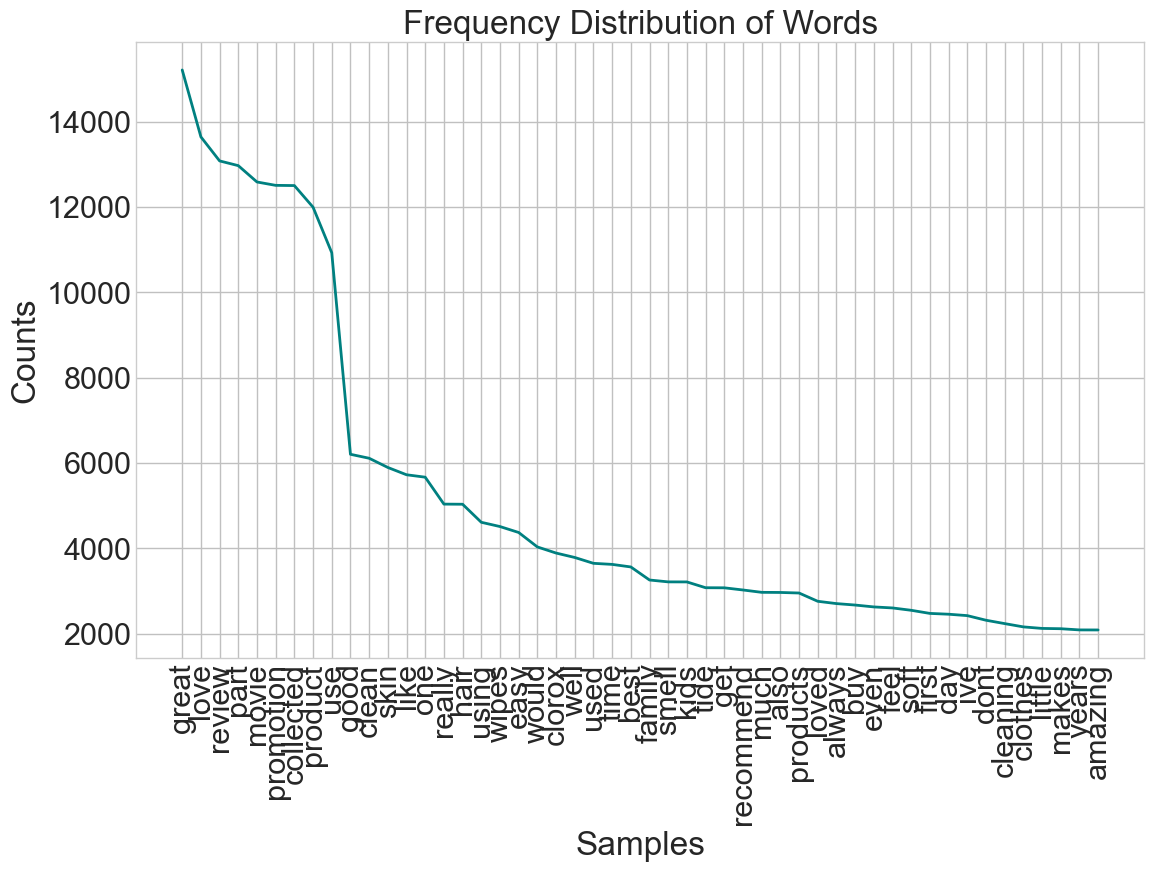

In [54]:
nested_pos = positive_revs.cleaned_reviews.str.split()
pos_flatlist = [element for inner_list in nested_pos for element in inner_list]

# -- plot --
plt.figure(figsize=(13, 8))
plt.style.use('seaborn-whitegrid')
freq_dist = FreqDist(pos_flatlist)
freq_dist.plot(50, cumulative=False, color='teal', title="Frequency Distribution of Words in Positive Reviews")
plt.show()

## Frequency of words in negative reviews:

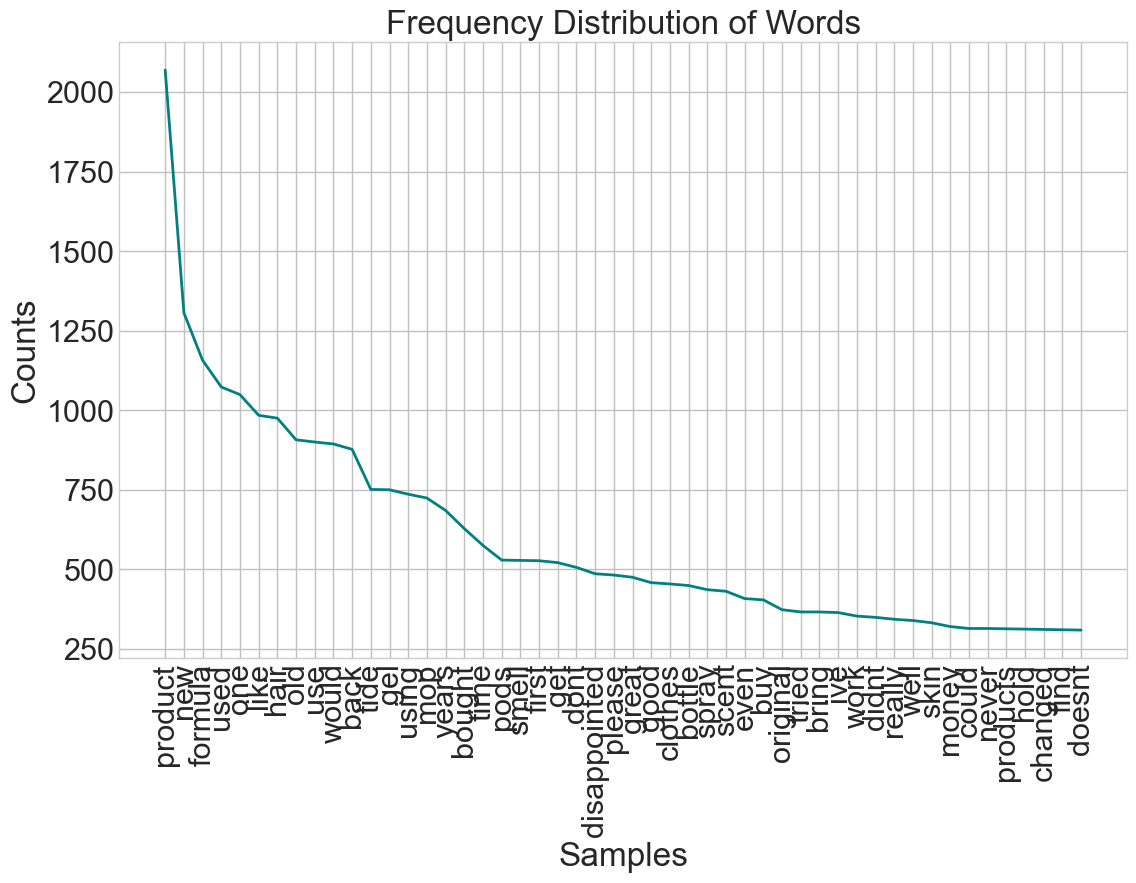

In [52]:
# -- Negative words freq count --
nested_neg = negative_revs.cleaned_reviews.str.split()
ne_flatlist = [element for inner_list in nested_neg for element in inner_list]

# -- plot --
plt.figure(figsize=(13, 8))
plt.style.use('seaborn-whitegrid')
freq_dist = FreqDist(ne_flatlist)
freq_dist.plot(50, cumulative=False, color='teal', title="Frequency Distribution of Words in Negative Reviews")
plt.show()

## Frequency of words in neutral reviews:

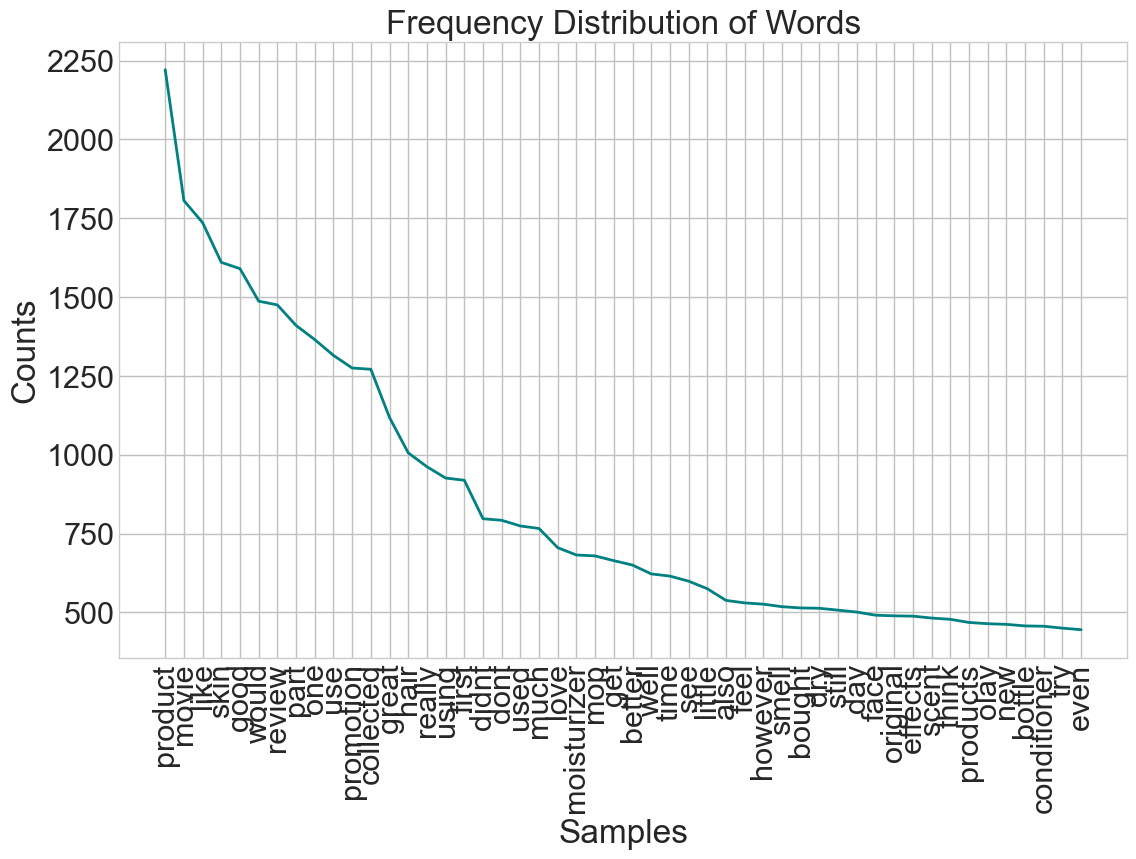

In [50]:
# -- Neutral words freq count --
nested_neut = neutral_reviews.cleaned_reviews.str.split()
neut_flatlist = [element for inner_list in nested_neut for element in inner_list]

# -- plot --
plt.figure(figsize=(13, 8))
plt.style.use('seaborn-whitegrid')
freq_dist = FreqDist(neut_flatlist)
freq_dist.plot(50, cumulative=False, color='teal', title="Frequency Distribution of Words in Neutral Reviews")
plt.show()